In [22]:
# For data analysis
import pandas as pd
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 5)
pd.set_option('display.max_colwidth', -1)
# For rendering animations inline
from IPython.display import HTML
# For plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.animation as animation
# For DICOM files
import pydicom
# For manipulating arrays
import numpy as np
# For handling files
import os

In [4]:
# The input files
CLINICAL_FILE = 'HNSCC-Clinical-Data.csv'
TREATMENT_FILE = 'Patient-and-Treatment-Characteristics.xls'
DESCRIPTION_FILE = 'Field-Descriptions-for-Patient-and-Treatment-Characteristics.xlsx'

# The description of various relevant clinical data
clinical_data = pd.read_csv(CLINICAL_FILE).sort_values(by=['TCIA Radiomics ID'])
# The descriptions of treatment dates and modalities
treatment_data = pd.read_excel(TREATMENT_FILE).sort_values(by=['TCIA code'])
# The descriptions of all the variables
description_data = pd.read_excel(DESCRIPTION_FILE)

In [5]:
# See what we data we can match
clinical_IDs = set(clinical_data['TCIA Radiomics ID'].tolist())
print('Number of clinical IDs: {}'.format(len(clinical_IDs)))
treatment_IDs = set(treatment_data['TCIA code'].tolist())
print('Number of treatment IDs: {}'.format(len(treatment_IDs)))
both_IDs = clinical_IDs & treatment_IDs
print('Number of both IDs: {}'.format(len(both_IDs)))

Number of clinical IDs: 492
Number of treatment IDs: 215
Number of both IDs: 80


In [6]:
# Find the description of a treatment variable here
VARIABLE_NAME = 'Received Feeding Tube (Y/N)'
# print(all_variables = description_data['Data Category'].tolist())
display(description_data.loc[description_data['Data Category'] == VARIABLE_NAME])

Data Category                        Description
41  Received Feeding Tube (Y/N)  Receipt of feeding tube during RT

In [7]:
# Extract cohort overview from the treatment data
count_list = {}
variables_to_include = {'Sex',
                        'Age',
                        'Diag',
                        'Survival (months)',
                        'Total RT treatment time (days)',
                        'Survival  (months)',
                        'Alive or Dead',
                        'Cause of Death'}
all_categories = description_data['Data Category'].tolist()
display(all_categories)
for key in all_categories[1:]:
    if key in variables_to_include:
        print('--------------------------------------------')
        print(key)
        print('--------------------------------------------')
        # Sort the index for these categories
        if key == 'Age' or 'Total RT treatment time (days)':
            temp_values = treatment_data[key].value_counts().sort_index(ascending=True)
        else:
            temp_values = treatment_data[key].value_counts()
        display(temp_values)
        count_list[key] = temp_values


['SUBJECT_ID',
 'Sex',
 'Age',
 'Date of Birth',
 'Diag',
 'Site',
 'Histology',
 'Grade',
 'T',
 'N',
 'M',
 'Stage',
 'HPV status',
 'Date of Diagnosis',
 'Last Contact Date',
 'Follow up duration (day)',
 'Follow up duration (year)',
 'Follow up duration (month)',
 'Date of Death',
 'Survival  (months)',
 'Alive or Dead',
 'Cause of Death',
 'Date of recurrence',
 'Disease-free interval (months)',
 'Site of recurrence (Distal/Local/ Locoregional)',
 'Overall Survival Censor',
 'Disease Specific Survival Censor',
 'Loco-regional Control Censor',
 'Oncologic Treatment Summary',
 'Induction Chemotherapy',
 'Chemotherapy Regimen',
 'Platinum-based chemotherapy',
 'Received Concurrent Chemoradiotherapy?',
 'CCRT Chemotherapy Regimen',
 'Surgery Summary',
 'RT Total Dose (Gy)',
 'Dose/Fraction (Gy/fx)',
 'Number of Fractions',
 'Unplanned Additional Oncologic Treatment',
 'Smoking History',
 'Current Smoker',
 'Received Feeding Tube (Y/N)',
 'Type of feeding tube',
 'Date Feeding tube pla

--------------------------------------------
Sex
--------------------------------------------


Female    33 
Male      182
Name: Sex, dtype: int64

--------------------------------------------
Age
--------------------------------------------


24    1
29    1
     ..
81    1
91    1
Name: Age, Length: 46, dtype: int64

--------------------------------------------
Diag
--------------------------------------------


CA BOT                              79
CA alveolar ridge                   1 
                                   .. 
NPC                                 6 
recurrence CA retromolar trigone    1 
Name: Diag, Length: 19, dtype: int64

--------------------------------------------
Survival  (months)
--------------------------------------------


6.333333      1
8.100000      1
             ..
116.449315    1
118.933333    1
Name: Survival  (months), Length: 209, dtype: int64

--------------------------------------------
Alive or Dead
--------------------------------------------


Alive    138
Dead     77 
Name: Alive or Dead, dtype: int64

--------------------------------------------
Cause of Death
--------------------------------------------


Alive           138
HN Cancer       52 
                .. 
Other cancer    4  
Unknown         9  
Name: Cause of Death, Length: 6, dtype: int64

--------------------------------------------
Total RT treatment time (days)
--------------------------------------------


23    2
24    1
     ..
49    2
51    1
Name: Total RT treatment time (days), Length: 21, dtype: int64

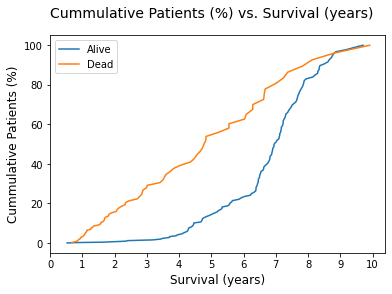

In [8]:
# Plot stuff here

# 1. Plot the cummulative survival for both alive and dead patients
key = 'Survival  (months)'
ad_data = treatment_data['Alive or Dead']
alive_filter = (ad_data=='Alive')
dead_filter = (ad_data=='Dead')
alive_data = treatment_data[key][alive_filter].sort_values()
dead_data = treatment_data[key][dead_filter].sort_values()

fig = plt.figure()
x_alive_data = pd.Series(alive_data.values).div(12)
y_alive_data = alive_data.cumsum().div(alive_data.sum()/100)
plt.plot(x_alive_data, y_alive_data, label = 'Alive')
x_dead_data = pd.Series(dead_data.values).div(12)
y_dead_data = dead_data.cumsum().div(dead_data.sum()/100)
plt.plot(x_dead_data, y_dead_data, label = 'Dead')
fig.suptitle('Cummulative Patients (%) vs. Survival (years)', fontsize=14)
plt.xlabel('Survival (years)', fontsize=12)
plt.ylabel('Cummulative Patients (%)', fontsize=12)
plt.xticks(np.arange(0, max(x_dead_data)+1, 1.0))
plt.legend()
plt.show()


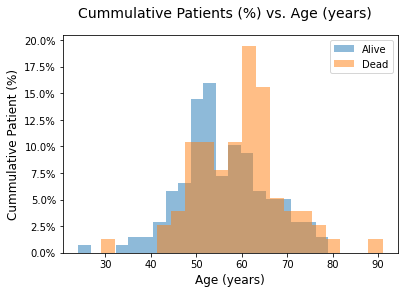

In [20]:
# 2. Plot the distribution of ages
key = 'Age'
alive_data = pd.Series(treatment_data[key][alive_filter].sort_values()).values
dead_data = pd.Series(treatment_data[key][dead_filter].sort_values()).values

fig = plt.figure()
nbins = 20
alive_weights=np.ones(len(alive_data)) / len(alive_data)
plt.hist(alive_data, bins=nbins, alpha=0.5, weights=alive_weights, label='Alive')
dead_weights=np.ones(len(dead_data)) / len(dead_data)
plt.hist(dead_data, bins=nbins, alpha=0.5, weights=dead_weights, label='Dead')
fig.suptitle('Cummulative Patients (%) vs. Age (years)', fontsize=14)
plt.xlabel('Age (years)', fontsize=12)
plt.ylabel('Cummulative Patient (%)', fontsize=12)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.show()

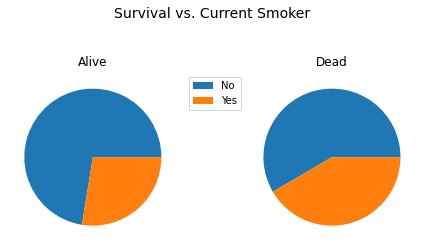

In [10]:
# 3. Plot the distribution of survival for current smoker
key = 'Current Smoker'
labels = ['No', 'Yes']
x_alive_data = treatment_data[key][alive_filter].value_counts().values
x_dead_data = treatment_data[key][dead_filter].value_counts().values

fig = plt.figure()
plt.subplot(1,2,1)
plt.title('Alive')
plt.pie(x_alive_data, labels=None)
plt.subplot(1,2,2)
plt.title('Dead')
plt.pie(x_dead_data, labels=None)
fig.suptitle('Survival vs. Current Smoker', fontsize=14)
plt.legend(labels, bbox_to_anchor=(0, 1))
plt.tight_layout()
plt.show()

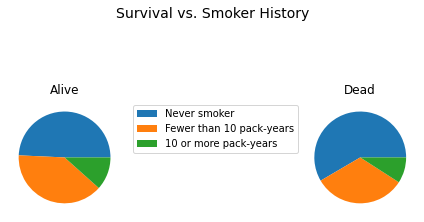

In [11]:
# 4. Plot the distribution of survival for smoker history
key = 'Smoking History'
labels = ['Never smoker', 'Fewer than 10 pack-years', '10 or more pack-years']
x_alive_data = treatment_data[key][alive_filter].value_counts().values
x_dead_data = treatment_data[key][dead_filter].value_counts().values

fig = plt.figure()
plt.subplot(1,2,1)
plt.title('Alive')
plt.pie(x_alive_data, labels=None)
plt.subplot(1,2,2)
plt.title('Dead')
plt.pie(x_dead_data, labels=None)
fig.suptitle('Survival vs. Smoker History', fontsize=14)
plt.legend(labels, bbox_to_anchor=(0, 1))
plt.tight_layout()
plt.show()

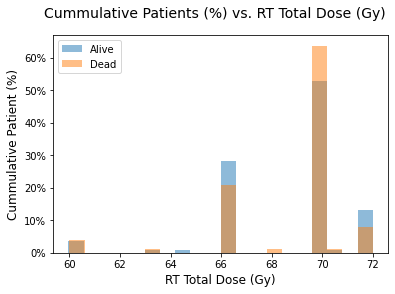

In [12]:
# 5. Plot the cummulative survival for both alive and dead patients
key = 'RT Total Dose (Gy)'
alive_data = pd.Series(treatment_data[key][alive_filter].sort_values()).values
dead_data = pd.Series(treatment_data[key][dead_filter].sort_values()).values

fig = plt.figure()
nbins = 20
plt.hist(alive_data, weights=np.ones(len(alive_data))/len(alive_data),
         bins=nbins, alpha=0.5, label='Alive')
plt.hist(dead_data, weights=np.ones(len(dead_data))/len(dead_data),
         bins=nbins, alpha=0.5, label='Dead')
fig.suptitle('Cummulative Patients (%) vs. RT Total Dose (Gy)', fontsize=14)
plt.xlabel('RT Total Dose (Gy)', fontsize=12)
plt.ylabel('Cummulative Patient (%)', fontsize=12)
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


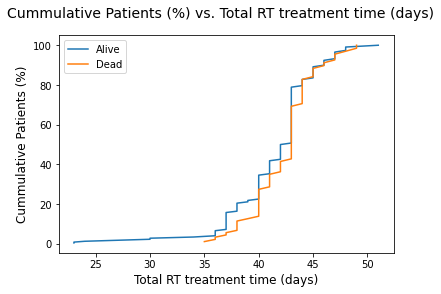

In [13]:
# 6. Plot the RT treatment time for both alive and dead patients
key = 'Total RT treatment time (days)'
ad_data = treatment_data['Alive or Dead']
alive_filter = (ad_data=='Alive')
dead_filter = (ad_data=='Dead')
alive_data = treatment_data[key][alive_filter].sort_values()
dead_data = treatment_data[key][dead_filter].sort_values()

fig = plt.figure()
x_alive_data = pd.Series(alive_data.values)
y_alive_data = alive_data.cumsum().div(alive_data.sum()/100)
plt.plot(x_alive_data, y_alive_data, label = 'Alive')
x_dead_data = pd.Series(dead_data.values)
y_dead_data = dead_data.cumsum().div(dead_data.sum()/100)
plt.plot(x_dead_data, y_dead_data, label = 'Dead')
fig.suptitle('Cummulative Patients (%) vs. Total RT treatment time (days)', fontsize=14)
plt.xlabel('Total RT treatment time (days)', fontsize=12)
plt.ylabel('Cummulative Patients (%)', fontsize=12)
plt.legend()
plt.show()

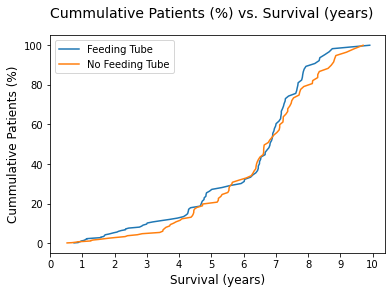

In [14]:
# 7. Plot the distribution of survival based on feeding tube
key = 'Survival  (months)'
ad_data = treatment_data['Received Feeding Tube (Y/N)']
tube_filter = (ad_data=='Yes')
no_tube_filter = (ad_data=='No')
tube_data = treatment_data[key][tube_filter].sort_values()
no_tube_data = treatment_data[key][no_tube_filter].sort_values()

fig = plt.figure()
x_alive_data = pd.Series(tube_data.values).div(12)
y_alive_data = tube_data.cumsum().div(tube_data.sum()/100)
plt.plot(x_alive_data, y_alive_data, label = 'Feeding Tube')
x_dead_data = pd.Series(no_tube_data.values).div(12)
y_dead_data = no_tube_data.cumsum().div(no_tube_data.sum()/100)
plt.plot(x_dead_data, y_dead_data, label = 'No Feeding Tube')
fig.suptitle('Cummulative Patients (%) vs. Survival (years)', fontsize=14)
plt.xlabel('Survival (years)', fontsize=12)
plt.ylabel('Cummulative Patients (%)', fontsize=12)
plt.xticks(np.arange(0, max(x_dead_data)+1, 1.0))
plt.legend()
plt.show()

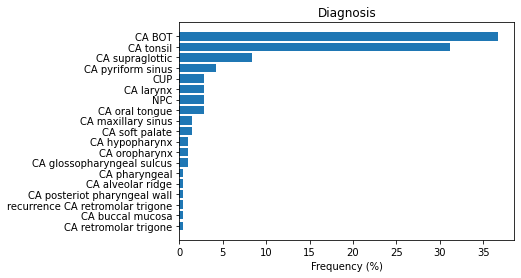

In [15]:
# 8. Plot the frequency of each diagnosis
y_value = treatment_data['Diag'].value_counts()
y_value = y_value.div(y_value.values.sum()/100)
y_pos = y_value.index

fig, ax = plt.subplots()
ax.barh(y_pos, y_value, align='center')
ax.set_yticks(y_pos)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency (%)')
ax.set_title('Diagnosis')
plt.show()

In [46]:
# Read, view, and animate CT files
FOLDER_PATH = os.path.join(
'HNSCC-01-0001',
'12-01-1998-PETCT HEAD  NECK CA-92442',
'2.000000-CT Atten Cor Head IN-25068'
# '4.000000-PET AC-13575'
# '5.000000-PET NO AC-29271'
# '601.000000-PETCoronal-08612'
)
all_dicom = os.listdir(FOLDER_PATH)

fig = plt.figure()
# Get all of the DICOM files in the directory
files = []
for dc in all_dicom:
    FULL_PATH = os.path.join(FOLDER_PATH, dc)
    ds = dcmread(FULL_PATH)
    if hasattr(ds, 'SliceLocation'):
        files.append(ds)

# Sort the DICOM into the correct order
slices = sorted(files, key=lambda s: s.SliceLocation)

# Plot the DICOM for each sorted file
images = []
for s in slices:
    images.append([
        plt.imshow(s.pixel_array,
                   cmap=plt.cm.gray,
                   animated=True)
    ])

# Create the animation
im_ani = animation.ArtistAnimation(fig,
                                   images,
                                   interval=50,
                                   repeat_delay=3000,
                                   blit=True)
# Save as a GIF if desired
# im_ani.save('CT_{}.gif'.format(FOLDER_PATH.replace(os.sep,'__')),
#             writer='Pillow',
#             fps=20)
plt.close()

In [47]:
# Render the animation in the notebook if desired
HTML(im_ani.to_jshtml())

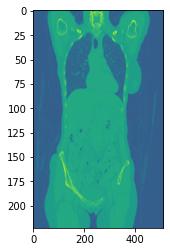

In [49]:
# Determine the ROI of the slices

# Load the DICOM files
files = []
dir_name = FOLDER_PATH
for fname in os.listdir(dir_name):
    ds = pydicom.dcmread(os.path.join(dir_name,fname))
    if hasattr(ds, 'SliceLocation'):
        files.append(ds)

# Ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# Get the pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# Create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# Fill 3D array with the images from the files
for i,s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# Display stacked slices
ax = plt.subplot()
plt.imshow(np.flipud(img3d[img_shape[0]//2, :, :].T))
ax.set_aspect(cor_aspect)

plt.show()